In [ ]:
!pip install fastai2 -q

     |████████████████████████████████| 184kB 2.9MB/s 


In [ ]:
import fastai2

In [ ]:
from fastai2.data.external import untar_data, URLs
from fastai2.data.transforms import get_image_files

In [ ]:
path = untar_data(URLs.PETS)
files = get_image_files(path/'images')
files

(#7390) [Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_109.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_46.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_88.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_129.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_15.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_7.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_78.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_79.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_162.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_194.jpg')...]

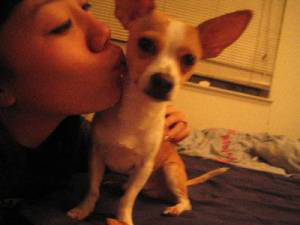

In [ ]:
import PIL
img = PIL.Image.open(files[0]); img

Use one func to wrap all preprocessing

In [ ]:
import torch
import numpy as np
def open_image(file, size=224):
    img = PIL.Image.open(file).convert('RGB')
    img = img.resize((size, size))
    # convert to tensor
    img = torch.tensor(np.array(img))
    return img.permute(2, 0, 1)/255.

In [ ]:
open_image(files[0]).shape

torch.Size([3, 224, 224])

the labeller

In [ ]:
import re
def labeller(file):
    lbl = re.match(r'^(.*)_\d+.jpg$', file.name).groups()[0]
    return lbl

In [ ]:
labels = list(set(files.map(labeller))); print(labels)

['newfoundland', 'boxer', 'yorkshire_terrier', 'Siamese', 'pomeranian', 'Russian_Blue', 'shiba_inu', 'leonberger', 'american_pit_bull_terrier', 'havanese', 'staffordshire_bull_terrier', 'Birman', 'Maine_Coon', 'Abyssinian', 'scottish_terrier', 'Bombay', 'japanese_chin', 'beagle', 'Egyptian_Mau', 'basset_hound', 'British_Shorthair', 'saint_bernard', 'Sphynx', 'chihuahua', 'Bengal', 'keeshond', 'Ragdoll', 'english_setter', 'pug', 'samoyed', 'german_shorthaired', 'great_pyrenees', 'wheaten_terrier', 'american_bulldog', 'miniature_pinscher', 'english_cocker_spaniel', 'Persian']


Create a label to all coressponding files dict

In [ ]:
lbl2files = {l: [file_ for file_ in files if l==labeller(file_)] for l in labels}

In [ ]:
# lbl2files

##Pytorch way

In [ ]:
import random

In [ ]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid=False):
        super(SiameseDataset, self).__init__()
        self.files, self.valid = files, is_valid
        if self.valid : 
            self.files_same = [self.draw(f) for f in files]

    def __len__(self):
        return len(files)

    def __getitem__(self, idx):
        file1 = self.files[0]
        (file2, same_breed) = self.files_same[0] if self.valid else self.draw(file1)
        img1, img2 = open_image(file1), open_image(file2)       
        return (img1, img2, torch.tensor([same_breed]).squeeze())

    def draw(self, f):
        # half the time the two images should be the same
        same_breed = random.random() < 0.5
        lbl = labeller(f)
        if not same_breed:
            lbl = random.choice([l for l in labels if l != lbl])
        # get the images from the dict
        return random.choice(lbl2files[lbl]), same_breed

get the train and valid sets

In [ ]:
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

In [ ]:
train_ds = SiameseDataset(train_files)
valid_ds = SiameseDataset(valid_files, is_valid=True)

We can now make a fastai dataloader

In [ ]:
from fastai2.data.core import DataLoaders

In [ ]:
dls = DataLoaders.from_dsets(train_ds, valid_ds)

In [ ]:
b = dls.one_batch()

## The fastai way using `Transform`

In [ ]:
from fastai2.vision.all import *

In [ ]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        super(SiameseTransform, self).__init__()
        self.files, self.valid = files, is_valid
        if self.valid : 
            self.files_same = [self.draw(f) for f in files]

    def encodes(self, idx):
        file1 = self.files[0]
        (file2, same_breed) = self.files_same[0] if self.valid else self.draw(file1)
        img1, img2 = open_image(file1), open_image(file2) 
        # this tume return fastai `TensorImage`      
        return (TensorImage(img1), TensorImage(img2), torch.tensor([same_breed]).squeeze())

    def draw(self, f):
        # half the time the two images should be the same
        same_breed = random.random() < 0.5
        lbl = labeller(f)
        if not same_breed:
            lbl = random.choice([l for l in labels if l != lbl])
        # get the images from the dict
        return random.choice(lbl2files[lbl]), same_breed

In [ ]:
tfm = SiameseTransform(files)

We can now use a TfmdList that takes only one pipeline to make apply the tfm then a Dls

In [ ]:
train_tl = TfmdLists(range(len(train_files)), [SiameseTransform(train_files)])
valid_tl = TfmdLists(range(len(valid_files)), [SiameseTransform(valid_files, is_valid=True)])

In [ ]:
dls = DataLoaders.from_dsets(train_tl, valid_tl)

In [ ]:
# dls.one_batch()

In [ ]:
tfm.show()

AttributeError: ignored

Let's make it work

we need to subclass from something that has a show method and why not a fastai `Tuple`

In [ ]:
class SiameseImage(Tuple):
    def show(self, ctx=None, **kwargs):
        img1, img2, same_breed = self
        # make sure the image is not a tensor mostlikely a pil
        if not isinstance(img1, Tensor):
            # make sure the pil are of the same size
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            # convert the pil to tensor
            t1, t2 = tensor(img1), tensor(img2)
            t1, t2 = t1.permute(2, 0, 1)/255., t2.permute(2, 0, 1)/255.
        else:
            t1, t2 = img1, img2
        # cretate a tensor of zeros
        line = t1.new_zeros((*t1.size()[:2], 10))
        return show_image(torch.cat([t1, line, t2], dim=2), title=same_breed, ctx=ctx, **kwargs)

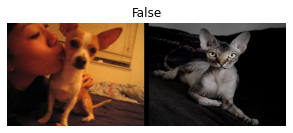

In [ ]:
img = PILImage.create(files[0])
img1 = PILImage.create(files[1])
s = SiameseImage(img, img1, False)
s.show();

Try again

In [ ]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        super(SiameseTransform, self).__init__()
        self.files, self.valid = files, is_valid
        if self.valid : 
            self.files_same = [self.draw(f) for f in files]

    def encodes(self, idx):
        file1 = self.files[0]
        (file2, same_breed) = self.files_same[0] if self.valid else self.draw(file1)
        img1, img2 = open_image(file1), open_image(file2) 
        # replave this
        return SiameseImage(img1, img2, same_breed)

    def draw(self, f):
        # half the time the two images should be the same
        same_breed = random.random() < 0.5
        lbl = labeller(f)
        if not same_breed:
            lbl = random.choice([l for l in labels if l != lbl])
        # get the images from the dict
        return random.choice(lbl2files[lbl]), same_breed

In [ ]:
tfm = SiameseTransform(files)

We can now use a TfmdList that takes only one pipeline to make apply the tfm then a Dls

In [ ]:
train_tl = TfmdLists(range(len(train_files)), [SiameseTransform(train_files)])
valid_tl = TfmdLists(range(len(valid_files)), [SiameseTransform(valid_files, is_valid=True)])

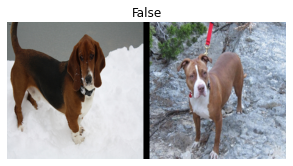

In [ ]:
show_at(train_tl, 0);

Rewrite encodes to accept files instead of int and accepts splits for valid

In [ ]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        super(SiameseTransform, self).__init__() 
        self.valid = {f: self.draw(f) for f in files[splits[1]]}

    def encodes(self, f):
        file1 = f
        (file2, same_breed) = self.valid.get(f, self.draw(f))
        img1, img2 = open_image(file1), open_image(file2) 
        # replave this
        return SiameseImage(img1, img2, same_breed)

    def draw(self, f):
        # half the time the two images should be the same
        same_breed = random.random() < 0.5
        lbl = labeller(f)
        if not same_breed:
            lbl = random.choice([l for l in labels if l != lbl])
        # get the images from the dict
        return random.choice(lbl2files[lbl]), same_breed

Use a random splitter

In [ ]:
splits = RandomSplitter()(files)

In [ ]:
tfm = SiameseTransform(files, splits)

In [ ]:
tls = TfmdLists(files, tfm, splits=splits)

In [ ]:
tls.valid

TfmdLists: [Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_223.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_19.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_169.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_90.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_178.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_3.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_56.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_106.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_129.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_192.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_93.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_180.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_103.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Bengal_87

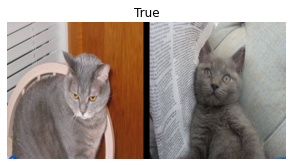

In [ ]:
show_at(tls.valid, 0);

In [ ]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor()], after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [ ]:
# dls.one_batch()

In [ ]:
type(dls.one_batch())

__main__.SiameseImage

In [ ]:
dls.show_batch()

TypeError: ignored

Make it work

We use typedispatch so we have to annotate one of the args to be of type `SiameseImage`

In [ ]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], x[2][i].item()).show(ctx=ctx)

another reason this works is because evrything in the batch is of a type `SiameseImage` so everything knwos how to show itself

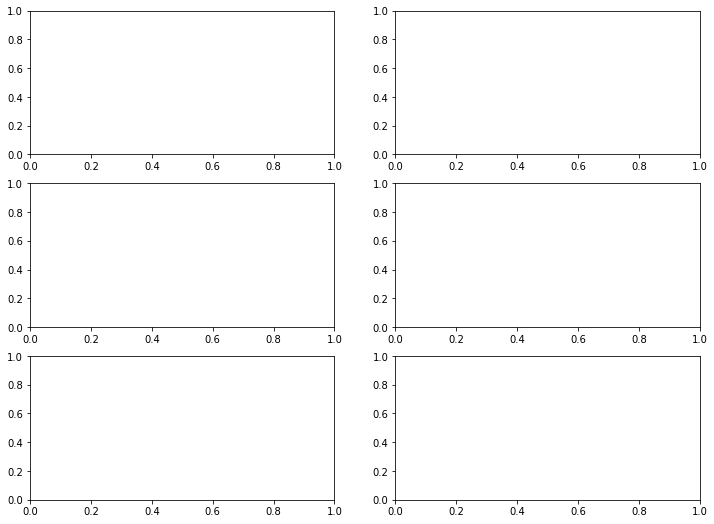

In [ ]:
get_grid(6, 3, 2, figsize=(12, 9))

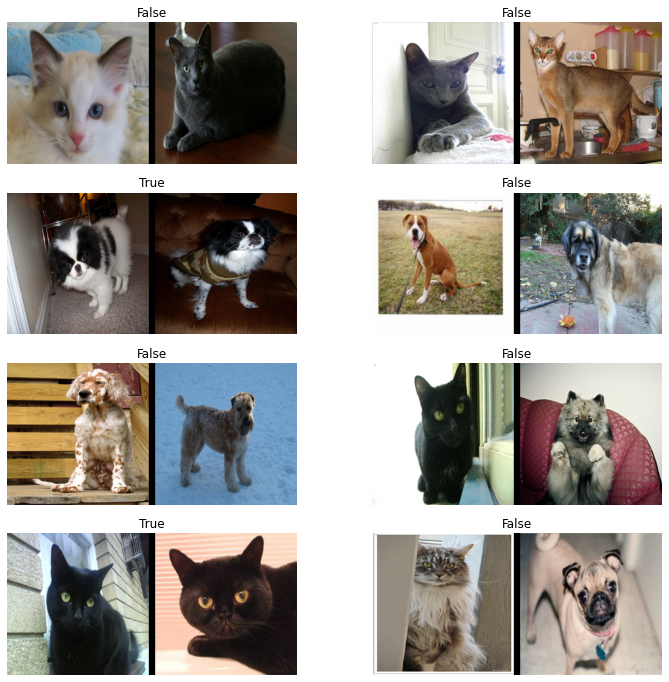

In [ ]:
dls.show_batch()

Writing custom DBlock

In the siamese problem, we have an ImageTuple of images and a Caegory target. let's say that our target is no longer cat then we have to create a custi=om datablock unless we know how to manipulate above to get what we want

In [ ]:
class ImageTuple(Tuple):
    @classmethod
    def create(cls, fns):return cls(Tuple(PILImage.create(f) for f in fns))

    def show(self, ctx=None, **kwargs):
        t1, t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape!=t2.shape: return ctx
        line = t1.new_zeros((*t1.shape[:2], 10))
        return show_image(torch.cat([t1, line, t2], dim=2), ctx=ctx, **kwargs)

type Tuple uses type dispacth to perform transfroms on all it's elements. So ToTensor() will be applied continuously on all the tuplified Tuple images

In [ ]:
img = ImageTuple.create((files[0], files[1]))
tst = ToTensor()(img)
type(tst[0]),type(tst[1])

(fastai2.torch_core.TensorImage, fastai2.torch_core.TensorImage)

In [ ]:
# we haven't resized the image sp it won't show
img.show();

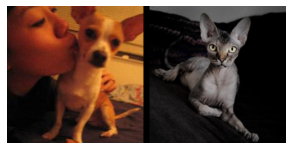

In [ ]:
img1 = Resize(224)(img)
tst = ToTensor()(img1)
tst.show()

Now let's make an ItemBlock!!. The has to be wrapped with a `TransformBlock`

In [ ]:
def ImageTupleBlock(): return TransformBlock(ImageTuple.create, batch_tfms=IntToFloatTensor)

In [ ]:
def draw(f):
    same_breed = random.random() < 0.5
    lbl = labeller(f)
    if not same_breed: lbl = random.choice(L(l for l in labels if l != lbl))
    return (random.choice(lbl2files[lbl]), same_breed)

In [ ]:
def get_tuple_files(path):
    files = get_image_files(path)
    return [[f, *draw(f)] for f in files]

In [ ]:
def get_x(t): return t[:2]
def get_y(t): return t[2]

In [ ]:
siamese = DataBlock(blocks=(ImageTupleBlock, CategoryBlock),
                    get_items = get_tuple_files,
                    get_x = get_x,
                    splitter=RandomSplitter(),
                    get_y=get_y,
                    item_tfms=Resize(224), 
                    batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = siamese.dataloaders(path/'images', path=path)

In [ ]:
explode_types(dls.one_batch())

{tuple: [{__main__.ImageTuple: [fastai2.torch_core.TensorImage,
    fastai2.torch_core.TensorImage]},
  fastai2.torch_core.TensorCategory]}

In [ ]:
@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    # for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], x[2][i].item()).show(ctx=ctx)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

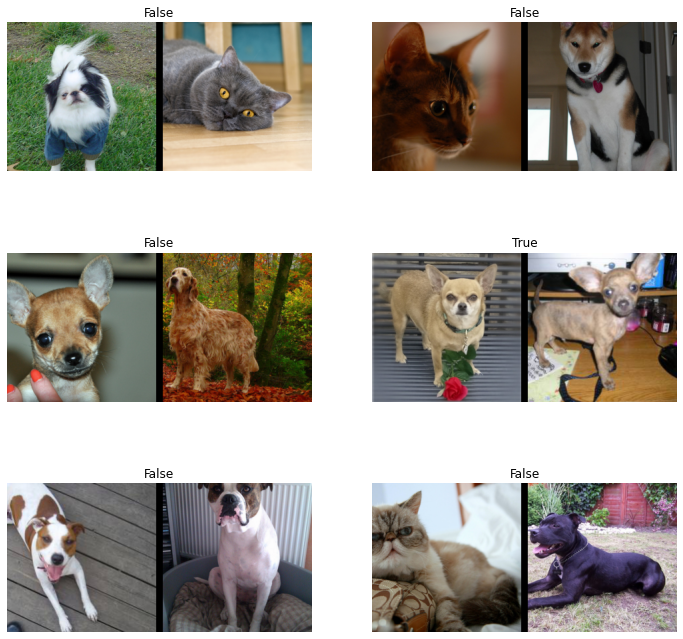

In [ ]:
dls.show_batch()